# Exploring Gaussian Processes with GPyTorch

Based on [GPyTorch docs](https://docs.gpytorch.ai/en/v1.2.0/examples/01_Exact_GPs/Simple_GP_Regression.html)

In [8]:
import math
import torch
import gpytorch

import matplotlib.pyplot as plt

import numpy as np

## Generate data

First, lets create a wiggly function that we want to model.

In [748]:
def fn(x):
    return torch.sin(x) * torch.exp(-0.2 * torch.abs(x))

In [749]:
x_true = torch.linspace(-20, 20, 300)
y_true = fn(x_true - 2)

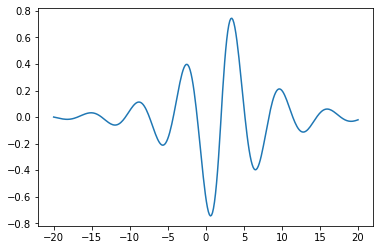

In [750]:
plt.plot(x_true, y_true)

Create a noisy variant with the ends cut-off

In [751]:
x_noise = x_true[50:250]
y_noise = y_true + 0.2 * torch.randn(len(y_true))
y_noise = y_noise[50:250]

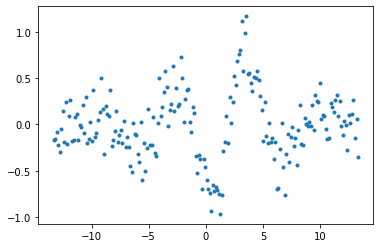

In [752]:
plt.plot(x_noise, y_noise, '.')

Finally, create a variant where the middle of the function is masked.

In [753]:
x_mask = torch.cat((x_true[:100], x_true[200:]))
y_mask = torch.cat((y_true[:100], y_true[200:]))
y_mask = y_mask + torch.randn(len(y_mask)) * 0.01

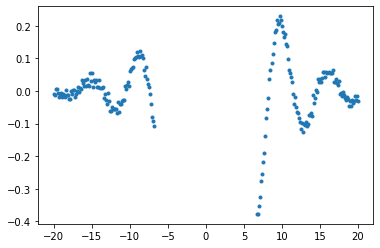

In [754]:
plt.plot(x_mask, y_mask, '.')

## RBF kernel

Let's first use the "standard" kernel, which enforces smoothness: nearby points can't have wildly differing function values.

In [755]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [756]:
training_iter = 100

def trainer(x, y, likelihood, model_cls, *args, **kwargs):
    model = model_cls(x, y, likelihood, *args, **kwargs)
    def train(x, y, training_iter=100, lr=0.1):
        # Find optimal model hyperparameters
        model.train()
        likelihood.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(x)
            # Calc loss and backprop gradients
            loss = -mll(output, y)
            loss.backward()
            if i % 10 == 9:
                print(f"Iter {i+1}/{training_iter} - Loss: {loss.item()}")
            optimizer.step()

        return model, likelihood
    
    return train

def fit_and_plot(train, x, y, x_test, y_test):

    model_true, ll_true = train(x, y, lr=0.1)
    model_true.eval()
    ll_true.eval()
    f_pred = ll_true(model_true(x_test))

    lower, upper = f_pred.confidence_region()

    f, ax = plt.subplots()

    ax.plot(x_test, y_test, color='black', alpha=0.3)
    ax.plot(x_test, f_pred.mean.detach().numpy(), '.')

    ax.fill_between(x_test, lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    
    ax.plot(x, y, '.', alpha=0.3)


Iter 10/100 - Loss: 0.492225706577301
Iter 20/100 - Loss: 0.035286154597997665
Iter 30/100 - Loss: -0.42899850010871887
Iter 40/100 - Loss: -0.9060688018798828
Iter 50/100 - Loss: -1.3774276971817017
Iter 60/100 - Loss: -1.8291804790496826
Iter 70/100 - Loss: -2.240196466445923
Iter 80/100 - Loss: -2.5772757530212402
Iter 90/100 - Loss: -2.812222957611084
Iter 100/100 - Loss: -2.9500772953033447


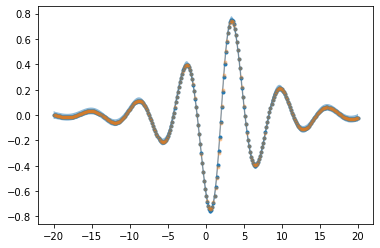

In [757]:
train = trainer(x_true, y_true, 
                gpytorch.likelihoods.GaussianLikelihood(), ExactGPModel)

fit_and_plot(train, x_true, y_true, x_true, y_true)

Iter 10/100 - Loss: 0.5493089556694031
Iter 20/100 - Loss: 0.1890123039484024
Iter 30/100 - Loss: -0.041279830038547516
Iter 40/100 - Loss: -0.058229751884937286
Iter 50/100 - Loss: -0.06098892167210579
Iter 60/100 - Loss: -0.0710575133562088
Iter 70/100 - Loss: -0.0696689635515213
Iter 80/100 - Loss: -0.07130439579486847
Iter 90/100 - Loss: -0.07112670689821243
Iter 100/100 - Loss: -0.0713304877281189


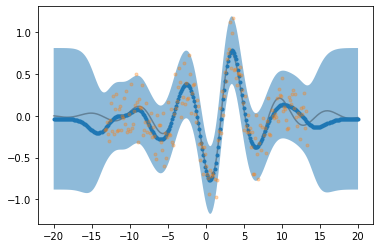

In [758]:
train = trainer(x_noise, y_noise, 
                gpytorch.likelihoods.GaussianLikelihood(), 
                ExactGPModel)

fit_and_plot(train, x_noise, y_noise, x_true, y_true)

Iter 10/100 - Loss: 0.4890090227127075
Iter 20/100 - Loss: 0.01061859168112278
Iter 30/100 - Loss: -0.48301565647125244
Iter 40/100 - Loss: -0.9628656506538391
Iter 50/100 - Loss: -1.443536639213562
Iter 60/100 - Loss: -1.885886549949646
Iter 70/100 - Loss: -2.2645809650421143
Iter 80/100 - Loss: -2.5338196754455566
Iter 90/100 - Loss: -2.6790521144866943
Iter 100/100 - Loss: -2.7409377098083496


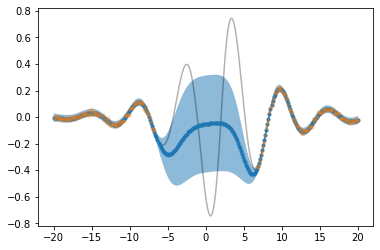

In [759]:
train = trainer(x_mask, y_mask, 
                gpytorch.likelihoods.GaussianLikelihood(), ExactGPModel)

fit_and_plot(train, x_mask, y_mask, x_true, y_true)

Note that this approach does not work well for the masked example, since within the mask there are no nearby points and hence the RBF kernel doesn't know what to do.

## Spectral Mixture Kernel

The [Spectral Mixture kernel](https://arxiv.org/pdf/1302.4245.pdf) learns a stationary kernel that can be more expressive.

In [760]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_mixtures=3):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=n_mixtures)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


Iter 10/100 - Loss: 0.5191562175750732
Iter 20/100 - Loss: 0.0923403948545456
Iter 30/100 - Loss: -0.269469290971756
Iter 40/100 - Loss: -0.8661630153656006
Iter 50/100 - Loss: -1.3577793836593628
Iter 60/100 - Loss: -1.882947564125061
Iter 70/100 - Loss: -2.289966583251953
Iter 80/100 - Loss: -2.6426870822906494
Iter 90/100 - Loss: -2.870828866958618
Iter 100/100 - Loss: -2.9931387901306152


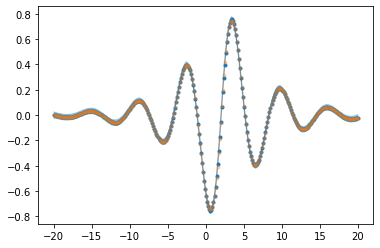

In [765]:
train = trainer(x_true, y_true, 
                gpytorch.likelihoods.GaussianLikelihood(), SpectralMixtureGPModel)
fit_and_plot(train, x_true, y_true, x_true, y_true)

Iter 10/100 - Loss: 0.5370317697525024
Iter 20/100 - Loss: 0.15326790511608124
Iter 30/100 - Loss: -0.0808490738272667
Iter 40/100 - Loss: -0.10492988675832748
Iter 50/100 - Loss: -0.11908622831106186
Iter 60/100 - Loss: -0.13149872422218323
Iter 70/100 - Loss: -0.13102462887763977
Iter 80/100 - Loss: -0.1332935392856598
Iter 90/100 - Loss: -0.13345246016979218
Iter 100/100 - Loss: -0.1337088793516159


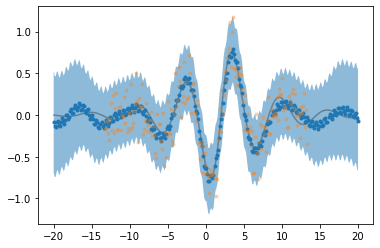

In [775]:
train = trainer(x_noise, y_noise, 
                gpytorch.likelihoods.GaussianLikelihood(), SpectralMixtureGPModel)
fit_and_plot(train, x_noise, y_noise, x_true, y_true)

We note that it may fail to converge to a good solution, hence requires a number of restarts.

Iter 10/100 - Loss: 0.4269508123397827
Iter 20/100 - Loss: -0.026626434177160263
Iter 30/100 - Loss: -0.4978397488594055
Iter 40/100 - Loss: -0.939805805683136
Iter 50/100 - Loss: -1.3381216526031494
Iter 60/100 - Loss: -1.8327724933624268
Iter 70/100 - Loss: -2.2253005504608154
Iter 80/100 - Loss: -2.5369527339935303
Iter 90/100 - Loss: -2.7150521278381348
Iter 100/100 - Loss: -2.796938180923462


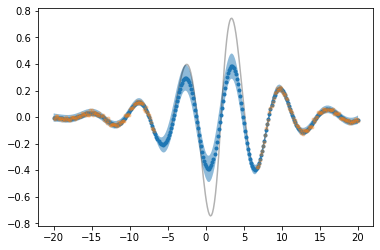

In [773]:
train = trainer(x_mask, y_mask, 
                gpytorch.likelihoods.GaussianLikelihood(), SpectralMixtureGPModel, 
                n_mixtures=3)
fit_and_plot(train, x_mask, y_mask, x_true, y_true)

However, when the model converges, it's better able to leverage the global structure to come up with more accurate predictions than the RBF kernel. 

Do note that the confidence intervals are too narrow and don't contain the ground truth.